# Optuna Hyperparameter Tuning in DoubleML

## Comparing Tuned vs. Untuned Models

This notebook demonstrates the impact of hyperparameter tuning using Optuna on the performance of Double Machine Learning models. We'll run a simulation study to compare:

1. **Untuned Model**: Using default hyperparameters
2. **Grid Search Tuning**: Traditional exhaustive grid search
3. **Optuna (TPE)**: Bayesian optimization with Tree-structured Parzen Estimator
4. **Optuna (GP)**: Bayesian optimization with Gaussian Process sampler
5. **Optuna (Random)**: Random search baseline
6. **Optuna (NSGA-II)**: Evolutionary strategy sampler applied to a single-objective problem
7. **Optuna (Brute Force)**: Deterministic sampler that enumerates the discretized search space

We'll evaluate both statistical performance (bias, RMSE, coverage) and computational efficiency.

This notebook uses parallel processing with `joblib` to run multiple simulations simultaneously, allowing us to run more simulation repetitions in less time.

In [1]:
# Import required libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import doubleml as dml
from doubleml import DoubleMLData
from doubleml.plm.datasets import make_plr_turrell2018, make_plr_CCDDHNR2018

from lightgbm import LGBMRegressor

import warnings
import optuna

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
optuna.logging.set_verbosity(optuna.logging.WARNING)
np.random.seed(42)

## Data Generating Process

We use the data generating process from Chernozhukov et al. (2018) which implements a Partially Linear Regression (PLR) model where:
- $\theta_0 = 0.5$ is the true treatment effect (our target parameter)

In [2]:
# Configuration for simulation
N_SIM = 10  # Number of simulation runs (increased thanks to parallelization!)
N_OBS = 500  # Sample size per simulation
N_VARS = 50  # Number of covariates
TRUE_THETA = 0.5  # True treatment effect
N_JOBS = 8  # Number of parallel jobs (-1 = use all CPU cores)

print(f"Simulation Configuration:")
print(f"  • Sample size: {N_OBS}")
print(f"  • Number of covariates: {N_VARS}")
print(f"  • Simulation runs: {N_SIM}")
print(f"  • True treatment effect θ₀: {TRUE_THETA}")
print(f"  • Parallel jobs: {N_JOBS} (all available cores)")

Simulation Configuration:
  • Sample size: 500
  • Number of covariates: 50
  • Simulation runs: 10
  • True treatment effect θ₀: 0.5
  • Parallel jobs: 8 (all available cores)


In [3]:
# Check available CPU cores
import multiprocessing

n_cores = multiprocessing.cpu_count()
print(f"\nSystem Information:")
print(f"  • Available CPU cores: {n_cores}")
print(f"  • Will use: {n_cores if N_JOBS == -1 else N_JOBS} cores for parallel processing")


System Information:
  • Available CPU cores: 16
  • Will use: 8 cores for parallel processing


## Setup: Define Tuning Strategies

## Optuna Parameter Specification

Starting with the updated DoubleML implementation, Optuna tuning uses **native Optuna sampling methods** via **callable parameter specifications**. This provides maximum flexibility and aligns with Optuna's native API.

### Callable Format (Required for Optuna)
```python
param_grid = {
    "ml_l": {
        "n_estimators": lambda trial, name: trial.suggest_int(name, 100, 500, step=50),
        "num_leaves": lambda trial, name: trial.suggest_int(name, 20, 256),
        "learning_rate": lambda trial, name: trial.suggest_float(name, 0.01, 0.3, log=True),
        "min_child_samples": lambda trial, name: trial.suggest_int(name, 5, 100),
    }
}
```

This format:
- Uses Optuna's native suggest methods (`suggest_int`, `suggest_float`, `suggest_categorical`)
- Enables **log-uniform** sampling for shrinkage parameters such as `learning_rate`
- Provides full control over parameter distributions
- Supports logarithmic scales, steps, and custom distributions
- Works with all Optuna samplers (TPE, GP, Random, etc.)

### Grid Search Format (For Comparison)
```python
param_grid = {
    "ml_l": {
        "n_estimators": [100, 200],  # Exhaustive search over these values
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "min_child_samples": [10, 30],
    }
}
```

In [ ]:
optuna_trials = 10  # Number of trials for each Optuna sampler

# Grid search: Uses list-based specification for LightGBM
param_grid_lgbm_grid = {
    "ml_l": {
        "n_estimators": [100, 200],
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "min_child_samples": [10, 30],
    },
    "ml_m": {
        "n_estimators": [100, 200],
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "min_child_samples": [10, 30],
    },
}

# Optuna: Callable-based specification aligned with LightGBM API
param_grid_lgbm_optuna_callable = {
    "ml_l": {
        "n_estimators": lambda trial, name: trial.suggest_int(name, 100, 500, step=50),
        "num_leaves": lambda trial, name: trial.suggest_int(name, 20, 256),
        "learning_rate": lambda trial, name: trial.suggest_float(name, 0.01, 0.3, log=True),
        "min_child_samples": lambda trial, name: trial.suggest_int(name, 5, 100),
        "colsample_bytree": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
    },
    "ml_m": {
        "n_estimators": lambda trial, name: trial.suggest_int(name, 100, 500, step=50),
        "num_leaves": lambda trial, name: trial.suggest_int(name, 20, 256),
        "learning_rate": lambda trial, name: trial.suggest_float(name, 0.01, 0.3, log=True),
        "min_child_samples": lambda trial, name: trial.suggest_int(name, 5, 100),
        "colsample_bytree": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
    },
}

# Optuna: Discretized callable specification for BruteForce sampler
bf_n_estimators = [100, 200, 300, 400, 500]
bf_num_leaves = [31, 63, 127, 255]
bf_learning_rate = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
bf_min_child_samples = [5, 10, 20, 50, 100]
bf_colsample_bytree = [0.5, 0.7, 0.9, 1.0]

param_grid_lgbm_optuna_callable_bruteforce = {
    "ml_l": {
        "n_estimators": lambda trial, name: trial.suggest_categorical(name, bf_n_estimators),
        "num_leaves": lambda trial, name: trial.suggest_categorical(name, bf_num_leaves),
        "learning_rate": lambda trial, name: trial.suggest_categorical(name, bf_learning_rate),
        "min_child_samples": lambda trial, name: trial.suggest_categorical(name, bf_min_child_samples),
        "colsample_bytree": lambda trial, name: trial.suggest_categorical(name, bf_colsample_bytree),
    },
    "ml_m": {
        "n_estimators": lambda trial, name: trial.suggest_categorical(name, bf_n_estimators),
        "num_leaves": lambda trial, name: trial.suggest_categorical(name, bf_num_leaves),
        "learning_rate": lambda trial, name: trial.suggest_categorical(name, bf_learning_rate),
        "min_child_samples": lambda trial, name: trial.suggest_categorical(name, bf_min_child_samples),
        "colsample_bytree": lambda trial, name: trial.suggest_categorical(name, bf_colsample_bytree),
    },
}

# Optuna settings with different samplers
optuna_settings_tpe = {
    "n_trials": optuna_trials,
    "sampler": optuna.samplers.TPESampler(seed=42),
    "show_progress_bar": False,
    "verbosity": optuna.logging.WARNING,
}

optuna_settings_gp = {
    "n_trials": optuna_trials,
    "sampler": optuna.samplers.GPSampler(seed=42),
    "show_progress_bar": False,
    "verbosity": optuna.logging.WARNING,
}

optuna_settings_random = {
    "n_trials": optuna_trials,
    "sampler": optuna.samplers.RandomSampler(seed=42),
    "show_progress_bar": False,
    "verbosity": optuna.logging.WARNING,
}

optuna_settings_nsga = {
    "n_trials": optuna_trials,
    "sampler": optuna.samplers.NSGAIISampler(seed=42),
    "show_progress_bar": False,
    "verbosity": optuna.logging.WARNING,
}

optuna_settings_bruteforce = {
    "n_trials": optuna_trials,
    "sampler": optuna.samplers.BruteForceSampler(seed=42),
    "show_progress_bar": False,
    "verbosity": optuna.logging.WARNING,
}

print("Grid Search Parameter Space:")
grid_combinations = 1
for values in param_grid_lgbm_grid["ml_l"].values():
    grid_combinations *= len(values)
print(f"  • Combinations per learner: {grid_combinations}")
print(f"  • Total evaluations (2 learners): {2 * grid_combinations}")
print(f"  • Grid search evaluates ALL combinations (exhaustive)")

print(f"\nOptuna Parameter Space (TPE / GP / Random / NSGA-II):")
print(f"  • n_estimators: integer range [100, 500] with step=50")
print(f"  • num_leaves: integer range [20, 256]")
print(f"  • learning_rate: log-uniform range [0.01, 0.3]")
print(f"  • min_child_samples: integer range [5, 100]")
print(f"  • colsample_bytree: continuous range [0.5, 1.0]")
print(f"  • Number of trials per learner: {optuna_trials}")
print(f"  • Total evaluations per sampler (2 learners): {2 * optuna_trials}")
print(f"  • Optuna uses intelligent sampling (not exhaustive)")

bf_total_candidates = len(bf_n_estimators) * len(bf_num_leaves) * len(bf_learning_rate) * len(bf_min_child_samples) * len(bf_colsample_bytree)
print(f"\nOptuna Parameter Space (Brute Force):")
print(f"  • All hyperparameters mapped to finite candidate sets to ensure enumeration")
print(f"  • Total candidate tuples per learner: {bf_total_candidates}")
print(f"  • Brute Force sampler exhaustively enumerates the discretized grid")

print(f"\nParameter Specification Format:")
print(f"  • All Optuna samplers: Callable-based format (maximum flexibility)")
print(f"  • Brute Force sampler receives discretized callables to keep the search space finite")

Grid Search Parameter Space:
  • Combinations per learner: 16
  • Total evaluations (2 learners): 32
  • Grid search evaluates ALL combinations (exhaustive)

Optuna Parameter Space (TPE / GP / Random / NSGA-II):
  • n_estimators: integer range [100, 500] with step=50
  • num_leaves: integer range [20, 256]
  • learning_rate: log-uniform range [0.01, 0.3]
  • min_child_samples: integer range [5, 100]
  • colsample_bytree: continuous range [0.5, 1.0]
  • Number of trials per learner: 10
  • Total evaluations per sampler (2 learners): 20
  • Optuna uses intelligent sampling (not exhaustive)

Optuna Parameter Space (Brute Force):
  • All hyperparameters mapped to finite candidate sets to ensure enumeration
  • Total candidate tuples per learner: 2400
  • Brute Force sampler exhaustively enumerates the discretized grid

Parameter Specification Format:
  • All Optuna samplers: Callable-based format (maximum flexibility)
  • Brute Force sampler receives discretized callables to keep the searc

## Simulation Study

We now benchmark seven tuning strategies across a factorial design inspired by Appendix D of [Chernozhukov et al., 2024](https://arxiv.org/pdf/2402.04674).
The study spans:
- **Sample sizes** `n ∈ {200, 500, 1000}`
- **Feature dimensions** `p ∈ {20, 100}`
- **Three data generating processes (DGPs)**: the two PLR benchmarks distributed with DoubleML and a custom sparse, heteroskedastic design.

For each configuration we repeat the experiment `N_SIM` times and evaluate:
1. **No tuning**: Default LightGBM parameters
2. **Grid search**: Exhaustive search over a discrete grid
3. **Optuna (TPE)**: Bayesian optimization with Tree-structured Parzen Estimator
4. **Optuna (GP)**: Gaussian Process sampler
5. **Optuna (Random)**: Random search baseline
6. **Optuna (NSGA-II)**: Evolutionary sampler for single-objective tuning
7. **Optuna (Brute Force)**: Enumerates a discretised search space via the Brute Force sampler

For every fitted DoubleML model we record the causal estimate, learner diagnostics (`evaluate_learners`), wall-clock time, and confidence-interval coverage. The plots below summarise how each tuning strategy scales with the problem dimensions and how much it improves upon the untuned baseline.

In [5]:
def _make_plr_sparse_heteroskedastic(n_obs, n_vars, theta, seed):
    """Custom partially linear DGP with sparse signal and heteroskedastic noise."""
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n_obs, n_vars))
    active = min(6, n_vars)
    beta = np.linspace(1.2, 0.4, active)
    signal = (X[:, :active] * beta).sum(axis=1)
    logits = 0.8 * X[:, 0] - 0.4 * X[:, 1] + 0.3 * X[:, 2] ** 2
    prob_treatment = 1.0 / (1.0 + np.exp(-logits))
    d = rng.binomial(1, prob_treatment).astype(float)
    hetero_scale = 0.5 + 0.4 * np.abs(X[:, 0])
    y = theta * d + signal + rng.normal(scale=hetero_scale, size=n_obs)
    feature_cols = [f"X{i+1}" for i in range(n_vars)]
    df = pd.DataFrame(X, columns=feature_cols)
    df.insert(0, "d", d)
    df.insert(0, "y", y)
    return df


def _generate_plr_data(dgp, n_obs, n_vars, theta, seed):
    """Helper to create PLR data for different data-generating processes."""
    if dgp == "turrell2018":
        return make_plr_turrell2018(n_obs=n_obs, dim_x=n_vars, theta=theta, return_type="DataFrame")
    if dgp == "ccddhnr2018":
        return make_plr_CCDDHNR2018(n_obs=n_obs, dim_x=n_vars, theta=theta, return_type="DataFrame")
    if dgp == "sparse_heteroskedastic":
        return _make_plr_sparse_heteroskedastic(n_obs=n_obs, n_vars=n_vars, theta=theta, seed=seed)
    raise ValueError(f"Unknown DGP '{dgp}'")


def run_single_simulation(
    seed,
    method="no_tuning",
    optuna_settings=None,
    n_obs=None,
    n_vars=None,
    dgp="turrell2018",
    theta=None,
 ):
    """Run a single simulation iteration for a given tuning strategy and DGP."""
    theta = TRUE_THETA if theta is None else theta
    n_obs = N_OBS if n_obs is None else n_obs
    n_vars = N_VARS if n_vars is None else n_vars

    # Generate data
    np.random.seed(seed)
    data = _generate_plr_data(dgp, n_obs=n_obs, n_vars=n_vars, theta=theta, seed=seed)

    # Prepare DoubleML data
    x_cols = [col for col in data.columns if col.startswith("X")]
    dml_data = DoubleMLData(data, "y", "d", x_cols)

    # Initialize learners with LightGBM base models
    base_params = {"random_state": seed, "n_jobs": 1, "verbosity": -1}
    ml_l = LGBMRegressor(**base_params)
    ml_m = LGBMRegressor(**base_params)

    # Initialize model
    dml_plr = dml.DoubleMLPLR(dml_data, ml_l, ml_m, n_folds=2, score="partialling out")

    start_time = time.time()

    # Apply tuning strategy
    if method == "grid_search":
        dml_plr.tune(param_grids=param_grid_lgbm_grid, search_mode="grid_search", n_folds_tune=3, set_as_params=True)
    elif method.startswith("optuna"):
        optuna_param_grids = param_grid_lgbm_optuna_callable
        if method == "optuna_bruteforce":
            optuna_param_grids = param_grid_lgbm_optuna_callable_bruteforce
        dml_plr.tune(
            param_grids=optuna_param_grids,
            search_mode="optuna",
            optuna_settings=optuna_settings,
            n_folds_tune=3,
            set_as_params=True,
        )
    # else: no_tuning - use defaults

    # Fit the model
    dml_plr.fit()

    elapsed_time = time.time() - start_time

    # Evaluate learners on cross-validated predictions (RMSE by default)
    learner_rmse = dml_plr.evaluate_learners()
    learner_rmse = {name: float(np.nanmean(values)) for name, values in learner_rmse.items()}

    # Extract results
    coef = dml_plr.coef[0]
    se = dml_plr.se[0]
    ci_lower, ci_upper = dml_plr.confint().values[0]

    return {
        "estimate": coef,
        "se": se,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "time": elapsed_time,
        "coverage": ci_lower <= theta <= ci_upper,
        "ml_l_rmse": learner_rmse.get("ml_l", np.nan),
        "ml_m_rmse": learner_rmse.get("ml_m", np.nan),
        "n_obs": n_obs,
        "n_vars": n_vars,
        "dgp": dgp,
        "theta": theta,
    }

In [11]:
# Extended simulation across sample sizes, feature dimensions, and DGPs
results = []

methods_config = [
    ("no_tuning", None, "No Tuning"),
    ("grid_search", None, "Grid Search"),
    ("optuna_tpe", optuna_settings_tpe, "Optuna (TPE Sampler)"),
    ("optuna_gp", optuna_settings_gp, "Optuna (GP Sampler)"),
    ("optuna_random", optuna_settings_random, "Optuna (Random Sampler)"),
    ("optuna_nsga", optuna_settings_nsga, "Optuna (NSGA-II Sampler)"),
    ("optuna_bruteforce", optuna_settings_bruteforce, "Optuna (Brute Force Sampler)"),
]

method_display_map = {key: display for key, _, display in methods_config}
method_palette = {
    "no_tuning": "#FF6B6B",
    "grid_search": "#4ECDC4",
    "optuna_tpe": "#45B7D1",
    "optuna_gp": "#96CEB4",
    "optuna_random": "#FFEAA7",
    "optuna_nsga": "#C792EA",
    "optuna_bruteforce": "#F5A65B",
}

dgp_grid = ["turrell2018", "ccddhnr2018", "sparse_heteroskedastic"]
dgp_labels = {
    "turrell2018": "Turrell et al. (2018)",
    "ccddhnr2018": "Chernozhukov et al. (2018)",
    "sparse_heteroskedastic": "Sparse + Heteroskedastic",
}
n_obs_grid = [200, 500, 1000]
n_vars_grid = [20, 100]

simulation_plan = list(product(dgp_grid, n_obs_grid, n_vars_grid))
total_settings = len(simulation_plan)
total_runs = total_settings * len(methods_config) * N_SIM

print("🚀 Extended simulation study")
print(f"   • Data generating processes: {', '.join(dgp_labels.values())}")
print(f"   • Sample sizes: {n_obs_grid}")
print(f"   • Feature dimensions: {n_vars_grid}")
print(f"   • Methods: {list(method_display_map.values())}")
print(f"   • Total fits (datasets × methods × sims): {total_runs:,}\n")

for setting_idx, (dgp, n_obs, n_vars) in enumerate(simulation_plan, start=1):
    setting_header = f"[Setting {setting_idx}/{total_settings}] DGP={dgp_labels[dgp]}, n={n_obs}, p={n_vars}"
    print(f"\n{'=' * len(setting_header)}")
    print(setting_header)
    print(f"{'=' * len(setting_header)}")
    for method_pos, (method_key, method_settings, display_name) in enumerate(methods_config):
        seed_offset = 10_000 * setting_idx + 1_000 * method_pos
        start_time = time.time()
        method_results = Parallel(n_jobs=N_JOBS, verbose=0)(
            delayed(run_single_simulation)(
                seed=seed_offset + i,
                method=method_key,
                optuna_settings=method_settings,
                n_obs=n_obs,
                n_vars=n_vars,
                dgp=dgp,
            )
            for i in range(N_SIM)
        )
        elapsed = time.time() - start_time
        for res in method_results:
            res.update({
                "method": method_key,
                "method_display": display_name,
                "dgp_label": dgp_labels[dgp],
            })
        results.extend(method_results)
        per_sim = elapsed / max(len(method_results), 1)
        print(f"  {display_name:<28s} {elapsed:6.1f}s total  |  {per_sim:.2f}s per simulation")

print("\n✅ Full simulation grid complete!\n")
results_df = pd.DataFrame(results)

🚀 Extended simulation study
   • Data generating processes: Turrell et al. (2018), Chernozhukov et al. (2018), Sparse + Heteroskedastic
   • Sample sizes: [200, 500, 1000]
   • Feature dimensions: [20, 100]
   • Methods: ['No Tuning', 'Grid Search', 'Optuna (TPE Sampler)', 'Optuna (GP Sampler)', 'Optuna (Random Sampler)', 'Optuna (NSGA-II Sampler)', 'Optuna (Brute Force Sampler)']
   • Total fits (datasets × methods × sims): 1,260


[Setting 1/18] DGP=Turrell et al. (2018), n=200, p=20


KeyboardInterrupt: 

## Analyze Results

Let's compute key performance metrics:
- **Bias**: How far estimates are from the truth on average
- **RMSE**: Root mean squared error (combines bias and variance)
- **Coverage**: Proportion of confidence intervals containing true value
- **Computation Time**: Wall-clock time for tuning + fitting
- **Learner RMSE**: Cross-validated RMSE from `evaluate_learners` for nuisance models (`ml_l`, `ml_m`)

In [28]:
if results_df.empty:
    raise RuntimeError("Simulation results are empty. Please run the previous cell.")

results_df = results_df.copy()
results_df["bias"] = results_df["estimate"] - results_df["theta"]
results_df["squared_error"] = results_df["bias"] ** 2

group_cols = ["dgp", "dgp_label", "n_obs", "n_vars", "method", "method_display"]
summary_df = (
    results_df.groupby(group_cols, as_index=False)
    .agg(
        avg_estimate=("estimate", "mean"),
        bias=("bias", "mean"),
        rmse_sq=("squared_error", "mean"),
        coverage_rate=("coverage", "mean"),
        avg_time=("time", "mean"),
        ml_l_rmse=("ml_l_rmse", "mean"),
        ml_m_rmse=("ml_m_rmse", "mean"),
        avg_se=("se", "mean"),
    )
)

summary_df["rmse"] = np.sqrt(summary_df.pop("rmse_sq"))
summary_df = summary_df.sort_values(["dgp", "n_obs", "n_vars", "method"])

display_cols = [
    "dgp_label",
    "n_obs",
    "n_vars",
    "method_display",
    "avg_estimate",
    "bias",
    "rmse",
    "coverage_rate",
    "avg_time",
    "ml_l_rmse",
    "ml_m_rmse",
    "avg_se",
 ]
summary_display = summary_df[display_cols].rename(
    columns={
        "dgp_label": "DGP",
        "n_obs": "n",
        "n_vars": "p",
        "method_display": "Method",
        "avg_estimate": "Avg. Estimate",
        "bias": "Bias",
        "rmse": "RMSE",
        "coverage_rate": "Coverage",
        "avg_time": "Avg. Time (s)",
        "ml_l_rmse": "Learner RMSE (ml_l)",
        "ml_m_rmse": "Learner RMSE (ml_m)",
        "avg_se": "Avg. SE",
    }
 )

formatted_summary = summary_display.copy()
for col in ["Avg. Estimate", "Bias", "RMSE", "Learner RMSE (ml_l)", "Learner RMSE (ml_m)", "Avg. SE"]:
    formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:+.4f}" if col == "Bias" else f"{x:.4f}")
formatted_summary["Coverage"] = formatted_summary["Coverage"].map(lambda x: f"{x:.2%}")
formatted_summary["Avg. Time (s)"] = formatted_summary["Avg. Time (s)"].map(lambda x: f"{x:.2f}")

print("\nKey performance summary across design settings:")
display(formatted_summary)


Key performance summary across design settings:


,DGP,n,p,Method,Avg. Estimate,Bias,RMSE,Coverage,Avg. Time (s),Learner RMSE (ml_l),Learner RMSE (ml_m),Avg. SE
0,Chernozhukov et al. (2018),200,20,Grid Search,0.4802,-0.0198,0.0647,90.00%,2.00,1.2277,1.2062,0.0623
1,Chernozhukov et al. (2018),200,20,No Tuning,0.4773,-0.0227,0.0737,90.00%,0.03,1.2913,1.1934,0.0674
2,Chernozhukov et al. (2018),200,20,Optuna (Brute Force Sampler),0.5408,+0.0408,0.0781,90.00%,3.62,1.3494,1.1402,0.0736
3,Chernozhukov et al. (2018),200,20,Optuna (GP Sampler),0.4721,-0.0279,0.1171,60.00%,1.51,1.2578,1.1627,0.0658
4,Chernozhukov et al. (2018),200,20,Optuna (NSGA-II Sampler),0.5310,+0.0310,0.0625,90.00%,1.46,1.2416,1.1498,0.0653
...,...,...,...,...,...,...,...,...,...,...,...,...
121,Turrell et al. (2018),1000,100,Optuna (Brute Force Sampler),0.4546,-0.0454,0.0517,80.00%,122.01,1.1674,1.0527,0.0318
122,Turrell et al. (2018),1000,100,Optuna (GP Sampler),0.4758,-0.0242,0.0286,100.00%,50.90,1.1823,1.0378,0.0324
123,Turrell et al. (2018),1000,100,Optuna (NSGA-II Sampler),0.4637,-0.0363,0.0498,90.00%,54.38,1.1767,1.0150,0.0336
124,Turrell et al. (2018),1000,100,Optuna (Random Sampler),0.4650,-0.0350,0.0423,90.00%,52.05,1.1679,1.0226,0.0328


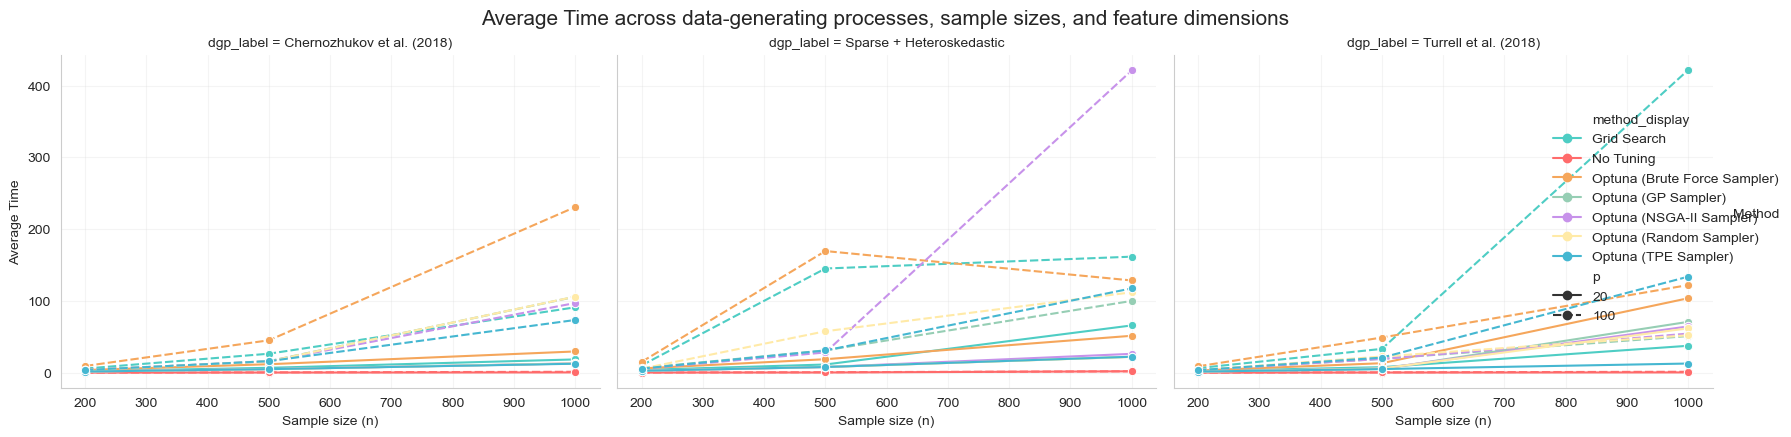

In [37]:
plot_rmse_df = summary_df.copy()
plot_rmse_df["n"] = plot_rmse_df["n_obs"]
plot_rmse_df["p"] = plot_rmse_df["n_vars"]

plot_palette = {method_display_map[key]: color for key, color in method_palette.items()}

g = sns.relplot(
    data=plot_rmse_df,
    x="n",
    y="avg_time",
    hue="method_display",
    style="p",
    col="dgp_label",
    col_wrap=3,
    kind="line",
    marker="o",
    palette=plot_palette,
    height=4.2,
    aspect=1.2,
 )
g.set_axis_labels("Sample size (n)", "Average Time")
g.add_legend(title="Method")
for ax in g.axes.flat:
    ax.grid(True, alpha=0.2)
g.fig.suptitle("Average Time across data-generating processes, sample sizes, and feature dimensions", fontsize=15, y=1.03)
plt.show()

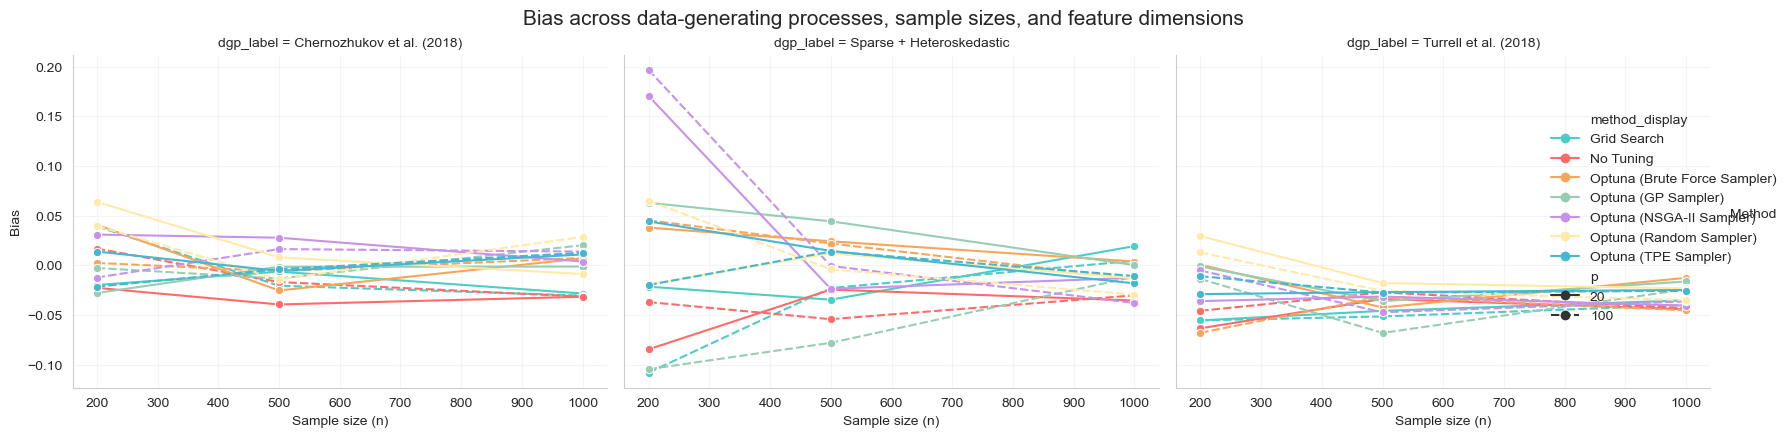

In [34]:
plot_rmse_df = summary_df.copy()
plot_rmse_df["n"] = plot_rmse_df["n_obs"]
plot_rmse_df["p"] = plot_rmse_df["n_vars"]

plot_palette = {method_display_map[key]: color for key, color in method_palette.items()}

g = sns.relplot(
    data=plot_rmse_df,
    x="n",
    y="bias",
    hue="method_display",
    style="p",
    col="dgp_label",
    col_wrap=3,
    kind="line",
    marker="o",
    palette=plot_palette,
    height=4.2,
    aspect=1.2,
 )
g.set_axis_labels("Sample size (n)", "Bias")
g.add_legend(title="Method")
for ax in g.axes.flat:
    ax.grid(True, alpha=0.2)
g.fig.suptitle("Bias across data-generating processes, sample sizes, and feature dimensions", fontsize=15, y=1.03)
plt.show()

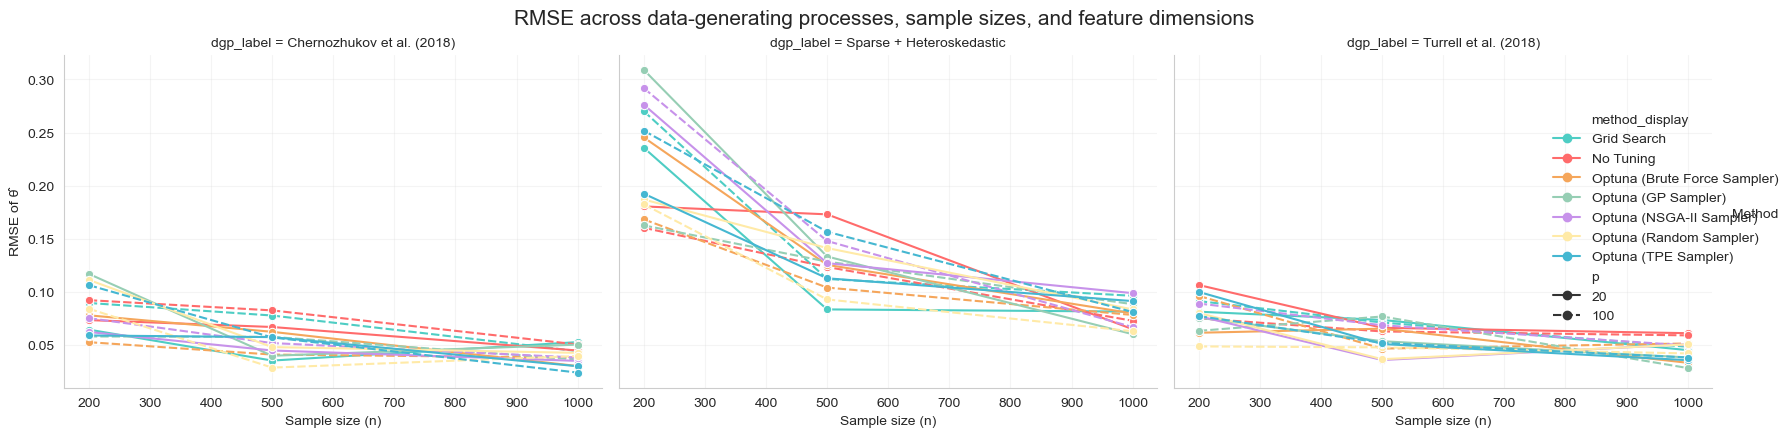

In [29]:
plot_rmse_df = summary_df.copy()
plot_rmse_df["n"] = plot_rmse_df["n_obs"]
plot_rmse_df["p"] = plot_rmse_df["n_vars"]

plot_palette = {method_display_map[key]: color for key, color in method_palette.items()}

g = sns.relplot(
    data=plot_rmse_df,
    x="n",
    y="rmse",
    hue="method_display",
    style="p",
    col="dgp_label",
    col_wrap=3,
    kind="line",
    marker="o",
    palette=plot_palette,
    height=4.2,
    aspect=1.2,
 )
g.set_axis_labels("Sample size (n)", "RMSE of θ̂")
g.add_legend(title="Method")
for ax in g.axes.flat:
    ax.grid(True, alpha=0.2)
g.fig.suptitle("RMSE across data-generating processes, sample sizes, and feature dimensions", fontsize=15, y=1.03)
plt.show()

In [32]:
# 3D interactive view of RMSE across sample sizes, feature dimensions, and tuning methods
import plotly.express as px

plot_rmse_3d_df = summary_df.copy()
plot_rmse_3d_df["n"] = plot_rmse_3d_df["n_obs"]
plot_rmse_3d_df["p"] = plot_rmse_3d_df["n_vars"]
plot_rmse_3d_df["DGP"] = plot_rmse_3d_df["dgp_label"]
plot_rmse_3d_df["Method"] = plot_rmse_3d_df["method_display"]

fig = px.scatter_3d(
    plot_rmse_3d_df,
    x="n",
    y="p",
    z="rmse",
    color="Method",
    symbol="DGP",
    hover_data={
        "n": True,
        "p": True,
        "rmse": ":.4f",
        "DGP": True,
    },
    labels={
        "n": "Sample size (n)",
        "p": "Feature dimension (p)",
        "rmse": "RMSE of θ̂",
    },
    color_discrete_map=plot_palette,
    height=650,
 )
fig.update_traces(marker=dict(size=9, line=dict(width=0.6, color="#222")))
fig.update_layout(
    title="3D RMSE landscape across sample sizes, feature dimensions, and tuning strategies",
    legend_title="Tuning Method",
    scene=dict(
        xaxis_title="Sample size (n)",
        yaxis_title="Feature dimension (p)",
        zaxis_title="RMSE of θ̂",
        xaxis=dict(backgroundcolor="#f8f8f8"),
        yaxis=dict(backgroundcolor="#f8f8f8"),
        zaxis=dict(backgroundcolor="#f8f8f8"),
    ),
    margin=dict(l=0, r=0, t=80, b=0),
 )
fig.show()

In [33]:
# 3D RMSE planes per DGP using fitted surfaces instead of scatter points
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

rmse_plane_df = summary_df.copy()
rmse_plane_df["n"] = rmse_plane_df["n_obs"]
rmse_plane_df["p"] = rmse_plane_df["n_vars"]
rmse_plane_df["Method"] = rmse_plane_df["method_display"]
rmse_plane_df["DGP"] = rmse_plane_df["dgp_label"]

dgp_order = list(dict.fromkeys(rmse_plane_df["DGP"]))
method_order = list(plot_palette.keys())

fig = make_subplots(
    rows=1,
    cols=len(dgp_order),
    specs=[[{"type": "scene"} for _ in dgp_order]],
    subplot_titles=dgp_order,
    horizontal_spacing=0.07,
 )

for col_idx, dgp_label in enumerate(dgp_order, start=1):
    subset = rmse_plane_df[rmse_plane_df["DGP"] == dgp_label]
    if subset.empty:
        continue
    for method in method_order:
        method_subset = subset[subset["Method"] == method]
        if method_subset.shape[0] < 3:
            continue
        x_vals = method_subset["n"].to_numpy(dtype=float)
        y_vals = method_subset["p"].to_numpy(dtype=float)
        z_vals = method_subset["rmse"].to_numpy(dtype=float)

        A = np.column_stack([x_vals, y_vals, np.ones_like(x_vals)])
        coeffs, *_ = np.linalg.lstsq(A, z_vals, rcond=None)
        a, b, c = coeffs

        x_min, x_max = x_vals.min(), x_vals.max()
        y_min, y_max = y_vals.min(), y_vals.max()
        corners = np.array(
            [[x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max]]
        )
        z_corners = a * corners[:, 0] + b * corners[:, 1] + c

        mesh = go.Mesh3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=z_corners,
            i=[0, 0],
            j=[1, 2],
            k=[2, 3],
            color=plot_palette[method],
            opacity=0.55,
            name=method,
            legendgroup=method,
            showlegend=(col_idx == 1),
            hovertemplate=(
                "Method: %s<br>n: %%{x:.0f}<br>p: %%{y:.0f}<br>Plane RMSE: %%{z:.4f}<extra></extra>"
                % method
            ),
        )
        fig.add_trace(mesh, row=1, col=col_idx)

    scene_idx = "scene" if col_idx == 1 else f"scene{col_idx}"
    fig.update_layout({
        scene_idx: dict(
            xaxis_title="Sample size (n)",
            yaxis_title="Feature dimension (p)",
            zaxis_title="RMSE of θ̂",
            xaxis=dict(backgroundcolor="#f9f9f9"),
            yaxis=dict(backgroundcolor="#f9f9f9"),
            zaxis=dict(backgroundcolor="#f9f9f9"),
        )
    })

fig.update_layout(
    title="Fitted RMSE planes per DGP and tuning strategy",
    legend_title="Tuning Method",
    margin=dict(l=0, r=0, t=80, b=0),
    height=450,
    width=420 * len(dgp_order),
)
fig.show()

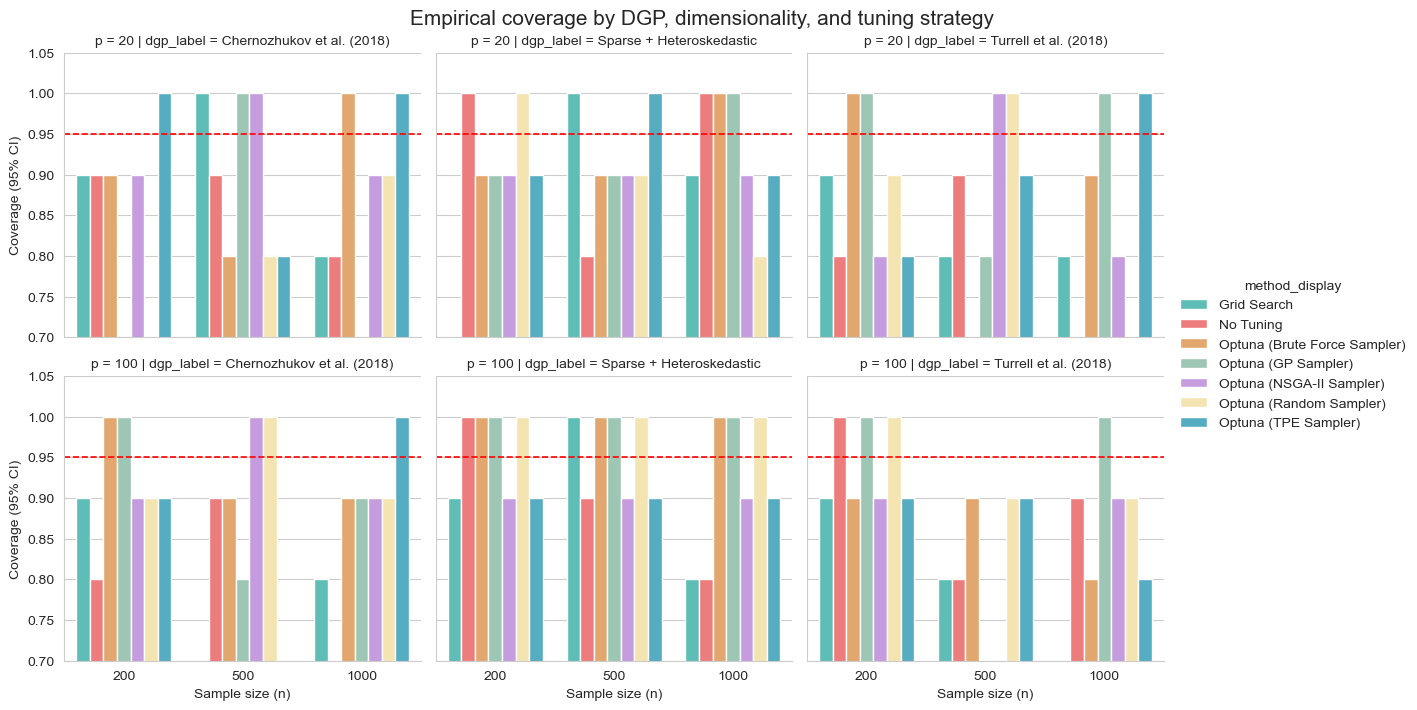

In [16]:
coverage_df = summary_df.copy()
coverage_df["n"] = coverage_df["n_obs"]
coverage_df["p"] = coverage_df["n_vars"]
coverage_df["coverage_gap"] = coverage_df["coverage_rate"] - 0.95

g = sns.catplot(
    data=coverage_df,
    x="n",
    y="coverage_rate",
    hue="method_display",
    col="dgp_label",
    row="p",
    kind="bar",
    palette=plot_palette,
    height=3.6,
    aspect=1.1,
 )
g.set_axis_labels("Sample size (n)", "Coverage (95% CI)")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Empirical coverage by DGP, dimensionality, and tuning strategy", fontsize=15)
for ax in g.axes.flat:
    ax.axhline(0.95, color="red", linestyle="--", linewidth=1.2)
    ax.set_ylim(0.7, 1.05)
plt.show()

### Learner Diagnostics from `evaluate_learners`

The bar charts below summarize the cross-validated RMSE returned by `evaluate_learners` for the outcome (`ml_l`) and treatment (`ml_m`) nuisance models across tuning strategies. Lower values indicate better predictive performance of the nuisance components.

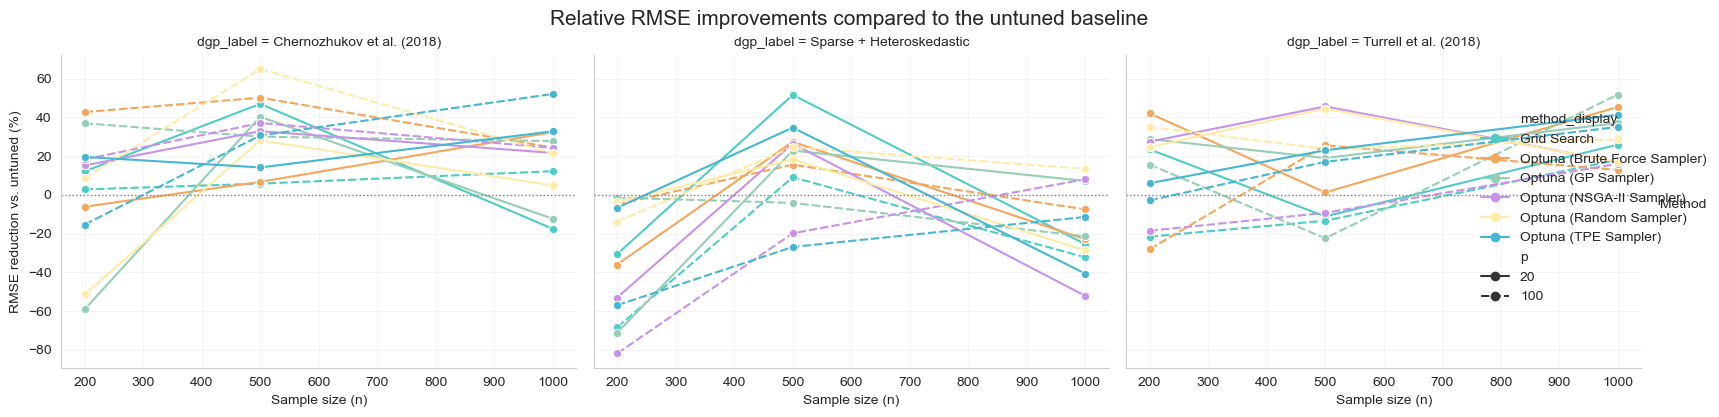

In [27]:
baseline_rmse = summary_df[summary_df["method"] == "no_tuning"][
    ["dgp", "n_obs", "n_vars", "rmse"]
].rename(columns={"rmse": "rmse_baseline"})

improvement_df = summary_df.merge(
    baseline_rmse, on=["dgp", "n_obs", "n_vars"], how="left"
 )
improvement_df = improvement_df[improvement_df["method"] != "no_tuning"].copy()
improvement_df["rmse_gain_pct"] = 100 * (improvement_df["rmse_baseline"] - improvement_df["rmse"]) / improvement_df["rmse_baseline"]
improvement_df["n"] = improvement_df["n_obs"]
improvement_df["p"] = improvement_df["n_vars"]

g = sns.relplot(
    data=improvement_df,
    x="n",
    y="rmse_gain_pct",
    hue="method_display",
    style="p",
    col="dgp_label",
    col_wrap=3,
    kind="line",
    marker="o",
    palette=plot_palette,
    height=4.0,
    aspect=1.2,
 )
g.set_axis_labels("Sample size (n)", "RMSE reduction vs. untuned (%)")
for ax in g.axes.flat:
    ax.axhline(0.0, color="gray", linestyle=":", linewidth=1)
    ax.grid(True, alpha=0.2)
g.add_legend(title="Method")
g.fig.suptitle("Relative RMSE improvements compared to the untuned baseline", fontsize=15, y=1.03)
plt.show()

In [26]:
# Visualize bias vs. learner RMSE diagnostics per (n, p) configuration with fitted hyperplanes
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

plot3d_df = summary_df.copy()
plot3d_df["Method"] = plot3d_df["method_display"]
plot3d_df["Sample size"] = plot3d_df["n_obs"]
plot3d_df["Features"] = plot3d_df["n_vars"]
plot3d_df["DGP"] = plot3d_df["dgp_label"]

n_levels = sorted(plot3d_df["Sample size"].unique())
p_levels = sorted(plot3d_df["Features"].unique())
method_order = list(plot_palette.keys())

fig = make_subplots(
    rows=len(p_levels),
    cols=len(n_levels),
    specs=[[{"type": "scene"} for _ in n_levels] for _ in p_levels],
    column_titles=[f"n = {n}" for n in n_levels],
    row_titles=[f"p = {p}" for p in p_levels],
    horizontal_spacing=0.04,
    vertical_spacing=0.06,
 )

for row_idx, p in enumerate(p_levels, start=1):
    for col_idx, n in enumerate(n_levels, start=1):
        subset = plot3d_df[(plot3d_df["Sample size"] == n) & (plot3d_df["Features"] == p)]
        if subset.empty:
            continue
        x_vals = subset["ml_l_rmse"].to_numpy()
        y_vals = subset["ml_m_rmse"].to_numpy()
        z_vals = subset["bias"].to_numpy()

        # Fit plane z = a*x + b*y + c
        A = np.column_stack([x_vals, y_vals, np.ones_like(x_vals)])
        coeffs, *_ = np.linalg.lstsq(A, z_vals, rcond=None)
        a, b, c = coeffs

        x_grid = np.linspace(x_vals.min(), x_vals.max(), 15)
        y_grid = np.linspace(y_vals.min(), y_vals.max(), 15)
        Xg, Yg = np.meshgrid(x_grid, y_grid)
        Zg = a * Xg + b * Yg + c

        surface = go.Surface(
            x=Xg,
            y=Yg,
            z=Zg,
            showscale=False,
            opacity=0.35,
            colorscale="Greys",
        )
        fig.add_trace(surface, row=row_idx, col=col_idx)

        for method in method_order:
            method_subset = subset[subset["Method"] == method]
            if method_subset.empty:
                continue
            scatter = go.Scatter3d(
                x=method_subset["ml_l_rmse"],
                y=method_subset["ml_m_rmse"],
                z=method_subset["bias"],
                mode="markers",
                name=method,
                marker=dict(
                    size=6,
                    color=plot_palette[method],
                    line=dict(width=0.5, color="#222"),
                ),
                hovertemplate=(
                    "Method: %{text}<br>ml_l RMSE: %{x:.4f}<br>ml_m RMSE: %{y:.4f}<br>Bias: %{z:+.4f}<br>DGP: %{customdata[0]}<extra></extra>"
                ),
                text=method_subset["Method"],
                customdata=method_subset[["DGP"]].to_numpy(),
                showlegend=(row_idx == 1 and col_idx == 1),
            )
            fig.add_trace(scatter, row=row_idx, col=col_idx)

        scene_idx = (row_idx - 1) * len(n_levels) + col_idx
        scene_name = "scene" if scene_idx == 1 else f"scene{scene_idx}"
        fig.update_layout({scene_name: dict(
            xaxis_title="ml_l RMSE",
            yaxis_title="ml_m RMSE",
            zaxis_title="Bias",
            xaxis=dict(backgroundcolor="#f9f9f9"),
            yaxis=dict(backgroundcolor="#f9f9f9"),
            zaxis=dict(backgroundcolor="#f9f9f9"),
        )})

fig.update_layout(
    height=380 * len(p_levels),
    width=420 * len(n_levels),
    title="Bias vs. learner RMSE diagnostics with fitted hyperplanes across (n, p) configurations",
    legend_title="Tuning Method",
    margin=dict(l=0, r=0, t=80, b=0),
 )
fig.show()

## Optuna Study Visualizations

Now let's visualize the Optuna optimization process using the built-in visualization tools. These visualizations help us understand:
- How the optimization progressed over trials
- Which hyperparameters were most important
- The relationships between hyperparameters and performance
- The parameter space exploration

We'll run a fresh Optuna tuning with `return_tune_res=True` to get the tuning results, which include the Optuna study objects for visualization.

In [18]:
# Run a single example to get the Optuna study objects for visualization
from doubleml.plm.datasets import make_plr_turrell2018

np.random.seed(123)
data = make_plr_turrell2018(n_obs=500, dim_x=20, theta=0.5, return_type="DataFrame")
x_cols = [col for col in data.columns if col.startswith("X")]
dml_data = DoubleMLData(data, "y", "d", x_cols)

# Initialize learners
base_params = {"random_state": 42, "n_jobs": 1, "verbosity": -1}
ml_l = LGBMRegressor(**base_params)
ml_m = LGBMRegressor(**base_params)

# Initialize model
dml_plr = dml.DoubleMLPLR(dml_data, ml_l, ml_m, n_folds=2, score="partialling out")

# Define parameter grid using callable format for LightGBM
param_grid_viz = {
    "ml_l": {
        "n_estimators": lambda trial, name: trial.suggest_int(name, 100, 600, step=50),
        "num_leaves": lambda trial, name: trial.suggest_int(name, 20, 256),
        "learning_rate": lambda trial, name: trial.suggest_float(name, 0.01, 0.3, log=True),
        "min_child_samples": lambda trial, name: trial.suggest_int(name, 5, 100),
        "colsample_bytree": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
        "subsample": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
    },
    "ml_m": {
        "n_estimators": lambda trial, name: trial.suggest_int(name, 100, 600, step=50),
        "num_leaves": lambda trial, name: trial.suggest_int(name, 20, 256),
        "learning_rate": lambda trial, name: trial.suggest_float(name, 0.01, 0.3, log=True),
        "min_child_samples": lambda trial, name: trial.suggest_int(name, 5, 100),
        "colsample_bytree": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
        "subsample": lambda trial, name: trial.suggest_float(name, 0.5, 1.0),
    },
}

# Tune with TPE sampler and more trials for better visualization
optuna_settings_viz = {
    "n_trials": 50,
    "sampler": optuna.samplers.TPESampler(seed=42),
    "show_progress_bar": True,
}

print("Running Optuna tuning for visualization...")
tune_res = dml_plr.tune(
    param_grids=param_grid_viz,
    search_mode="optuna",
    optuna_settings=optuna_settings_viz,
    n_folds_tune=3,
    set_as_params=False,  # Don't set params, we just want the study objects
    return_tune_res=True,  # Return the tuning results including study objects
)

print("\n✓ Tuning complete! Extracting study objects...")

# Extract the study objects from the tuning results
# tune_res is a list (one element per treatment variable)
# Each element is a dict with 'tune_res' key containing 'l_tune' and 'm_tune'
# Each of those is a list of tuning results (one per fold, but since tune_on_folds=False, just one element)
study_ml_l = tune_res[0]["tune_res"]["l_tune"][0].study_
study_ml_m = tune_res[0]["tune_res"]["m_tune"][0].study_

print(f"  • ml_l study: {len(study_ml_l.trials)} trials completed")
print(f"  • ml_m study: {len(study_ml_m.trials)} trials completed")


Running Optuna tuning for visualization...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-10-15 15:28:37,716] Trial 10 failed with parameters: {'n_estimators': 550, 'num_leaves': 249, 'learning_rate': 0.01034299287054877, 'min_child_samples': 100, 'colsample_bytree': 0.809377298679103, 'subsample': 0.6344859264658601} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Work\.conda\envs\dml_edit\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Work\Documents\GitHub\doubleml-for-py\doubleml\utils\_estimation.py", line 455, in objective
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "c:\Users\Work\.conda\envs\dml_edit\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Work\.conda\envs\dml_edit\Lib\site-packages\sklearn\model_selection\_validation.py", line 423, in cross_validate
  

KeyboardInterrupt: 

### 1. Optimization History

The optimization history plot shows how the objective value improves over trials. This helps us understand:
- Whether the optimization is converging
- How quickly good parameters are found
- If more trials might be beneficial

In [ ]:
from optuna.visualization import plot_optimization_history

# Plot optimization history for both learners
fig1 = plot_optimization_history(study_ml_l)
fig1.update_layout(title="Optimization History - ml_l (Outcome Model)", height=400)
fig1.show()

fig2 = plot_optimization_history(study_ml_m)
fig2.update_layout(title="Optimization History - ml_m (Treatment Model)", height=400)
fig2.show()

### 2. Parameter Importances

This visualization shows which hyperparameters had the most impact on model performance. Understanding parameter importance helps us:
- Focus tuning efforts on the most important parameters
- Simplify the search space for future runs
- Understand what matters for this specific dataset

In [ ]:
from optuna.visualization import plot_param_importances

# Plot parameter importances for both learners
fig3 = plot_param_importances(study_ml_l)
fig3.update_layout(title="Parameter Importances - ml_l (Outcome Model)", height=400)
fig3.show()

fig4 = plot_param_importances(study_ml_m)
fig4.update_layout(title="Parameter Importances - ml_m (Treatment Model)", height=400)
fig4.show()

### 3. Slice Plot

The slice plot shows the relationship between individual hyperparameters and the objective value. This helps us:
- See how each parameter affects performance
- Identify optimal ranges for each parameter
- Detect non-linear relationships

In [ ]:
from optuna.visualization import plot_slice

# Plot slice for ml_l
fig5 = plot_slice(study_ml_l)
fig5.update_layout(title="Hyperparameter Slice Plot - ml_l (Outcome Model)", height=500)
fig5.show()

# Plot slice for ml_m
fig6 = plot_slice(study_ml_m)
fig6.update_layout(title="Hyperparameter Slice Plot - ml_m (Treatment Model)", height=500)
fig6.show()

### 4. Contour Plot

The contour plot visualizes the interaction between pairs of hyperparameters. This is useful for:
- Understanding parameter interactions
- Identifying parameter combinations that work well together
- Detecting redundant parameters

We'll focus on the most important parameters identified earlier.

In [ ]:
from optuna.visualization import plot_contour

# Plot contour for ml_l
fig7 = plot_contour(study_ml_l)
fig7.update_layout(title="Hyperparameter Contour Plot - ml_l (Outcome Model)", height=600)
fig7.show()

# Plot contour for ml_m
fig8 = plot_contour(study_ml_m)
fig8.update_layout(title="Hyperparameter Contour Plot - ml_m (Treatment Model)", height=600)
fig8.show()

### 5. Parallel Coordinate Plot

This plot shows all trials in a parallel coordinate system, where each line represents one trial. It's useful for:
- Visualizing the full parameter space exploration
- Identifying clusters of good parameter combinations
- Understanding the sampler's exploration strategy

In [ ]:
from optuna.visualization import plot_parallel_coordinate

# Plot parallel coordinate for ml_l
fig9 = plot_parallel_coordinate(study_ml_l)
fig9.update_layout(title="Parallel Coordinate Plot - ml_l (Outcome Model)", height=500)
fig9.show()

# Plot parallel coordinate for ml_m
fig10 = plot_parallel_coordinate(study_ml_m)
fig10.update_layout(title="Parallel Coordinate Plot - ml_m (Treatment Model)", height=500)
fig10.show()

### 6. Empirical Distribution Function (EDF) Plot

The EDF plot shows the distribution of objective values across trials. This helps us:
- Understand the overall performance distribution
- Assess how often good parameters are found
- Compare the quality of different parameter regions

In [ ]:
from optuna.visualization import plot_edf

# Combine both studies for comparison
fig11 = plot_edf(study_ml_m, target_name="ml_m (Treatment)")
fig11.update_layout(title="Empirical Distribution Function", height=500)
fig11.show()

In [ ]:
fig11 = plot_edf(study_ml_l, target_name="ml_l (Outcome)")
fig11.update_layout(title="Empirical Distribution Function", height=500)
fig11.show()